In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pachner_traversal.utils import data_path, set_style, compute_rhat

set_style()

In [2]:
mcmc_result_path = data_path / "results" / "mcmc" / "generic_samples" / "20251004_1845"
assert mcmc_result_path.exists()

In [3]:
tet_map = {l: i for i, l in enumerate('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')}

In [4]:
def get_mcmc_scores_df(result_path, metric='agg_score_alex_norm'):
    isos_df = pd.read_csv(result_path / 'isos_lists.csv')
    scores_df = pd.read_csv(result_path / 'composite_scores.csv', index_col=0)

    scores_series = scores_df[metric]
    scores_map = scores_series.to_dict()

    chain_scores_df = isos_df.apply(lambda x: x.map(scores_map), axis=1)
    return chain_scores_df

In [39]:
metrics = [
    "agg_score_alex_norm",
    "agg_score_alex_deg",
    "agg_score_alex_det",
    "agg_score_edge_var",
    "agg_score_num_gen",
]

# mcmc_chain_scores = {}

# for metric in metrics:
#     mcmc_chain_scores_df = get_mcmc_scores_df(mcmc_result_path, metric)
#     mcmc_chain_scores[metric] = mcmc_chain_scores_df
#     rhat = compute_rhat(mcmc_chain_scores_df)[0]
#     print(f'{metric:20} | Rhat: {rhat:.3f}')

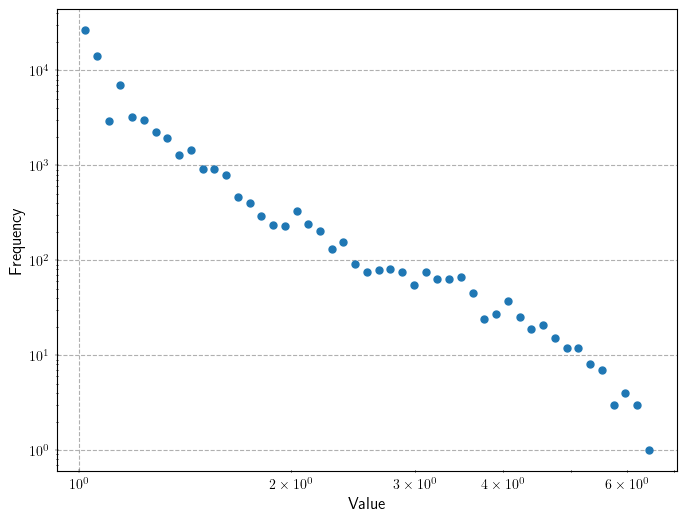

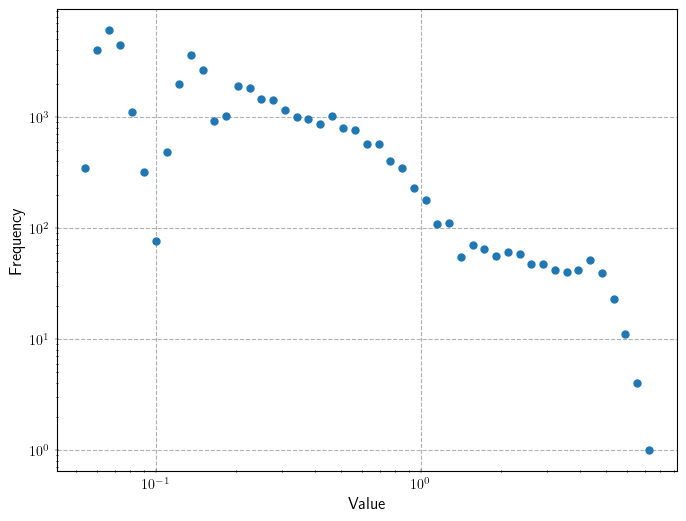

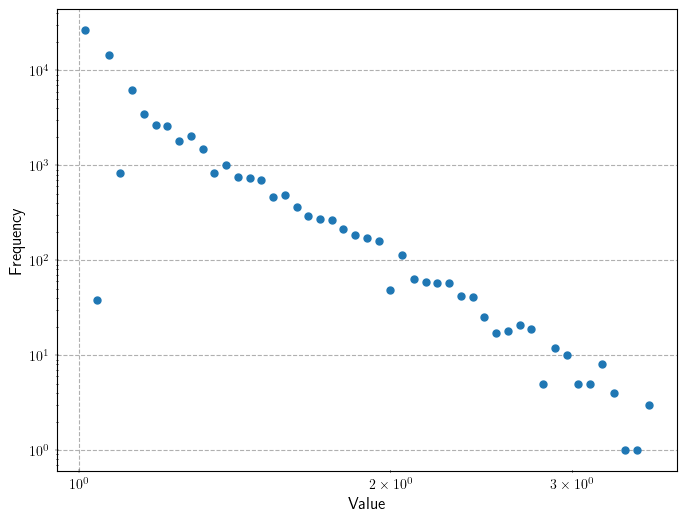

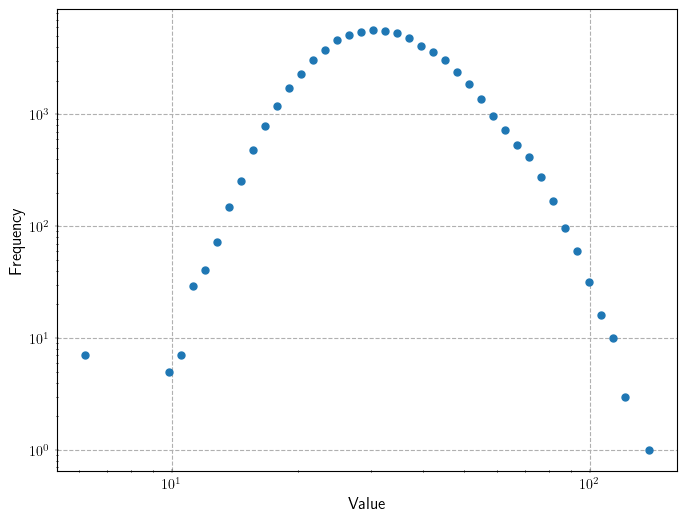

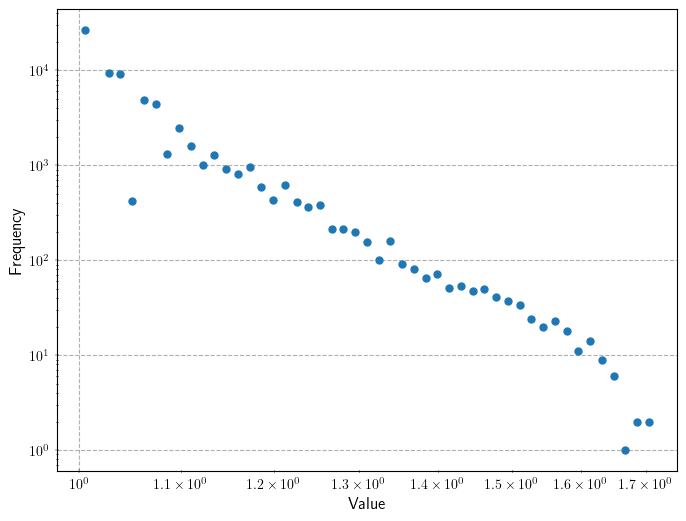

In [42]:
for metric in metrics:
    df = pd.read_csv(mcmc_result_path / f'{metric}_chains.csv', index_col=0)
    data = df.values.flatten()

    min_val = np.min(data[data > 0])  # Ensure positive values for log
    max_val = np.max(data)
    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=50)

    counts, bin_edges = np.histogram(data, bins=log_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    non_zero_indices = counts > 0
    x_values = bin_centers[non_zero_indices]
    y_values = counts[non_zero_indices]

    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, 'o', markersize=5, label='Power Law Data Binned')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid()
    plt.savefig(f'{metric}_log_distribution.pdf', dpi=300, bbox_inches='tight')
    plt.show()